In [1]:
!pip install requests python-chess

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.1/6.1 MB 57.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for chess: filename=chess-1.11.2-py3-none-any.whl size=147775 sha256=a7e3008282497f5787b3c13f3436e75ce43d2b0140ec0c5e828181fe8ab5aed6
  Stored in directory: /root/.cache/pip/wheels/fb/5d/5c/59a62d8a695285e59ec9c1f66add6f8a9ac4152499a2be0113
Successfully built chess


In [2]:
!pip install gymnasium stable-baselines3[extra]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 123.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 96.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 58.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 43.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 87.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.5/184.5 kB 17.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninst

# **Import Statements**

In [ ]:
import chess
import chess.pgn
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from collections import deque
from torch.utils.data import TensorDataset, DataLoader, random_split
import requests
import bz2
import os 
import gymnasium as gym
from gymnasium import spaces
from stable_baselines3 import PPO
from stable_baselines3.common.policies import ActorCriticPolicy
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor
from stable_baselines3.common.vec_env import DummyVecEnv
from torch.distributions import Categorical 
import matplotlib.pyplot as plt

# **Constants**

In [ ]:
QUEEN_DIR_OFFSETS = [
    (0, 1), (1, 1), (1, 0), (1, -1),
    (0, -1), (-1, -1), (-1, 0), (-1, 1)
] 
QUEEN_LIKE_MOVES_PLANES = 56

KNIGHT_MOVES_OFFSETS = [
    (1, 2), (2, 1), (2, -1), (1, -2),
    (-1, -2), (-2, -1), (-2, 1), (-1, 2)
]
KNIGHT_MOVES_PLANES = 8

PAWN_PROMOTION_TYPES = [
    (0, 1),   
    (-1, 1),  
    (1, 1)    
]
PROMOTION_PIECES_ORDER = [chess.QUEEN, chess.ROOK, chess.BISHOP]
PAWN_PROMOTION_PLANES = 9 

TOTAL_ACTION_PLANES = QUEEN_LIKE_MOVES_PLANES + KNIGHT_MOVES_PLANES + PAWN_PROMOTION_PLANES 
POLICY_OUTPUT_SIZE = TOTAL_ACTION_PLANES * 64 


# **Data Extraction**

In [ ]:
def download_magnus_carlsen_game(username: str, max_games: int = 1, perf_type: str = None, output_filename: str = "games.pgn"):
    print(f"Attempting to download {max_games} {perf_type if perf_type else 'any'} game(s) for user: {username}")
    url = f"https://lichess.org/api/games/user/{username}"
    params = {
        'max': max_games,
        'perfType': perf_type,
        'moves': 1, 
        'pgnInJson': 0,
        'clocks': 0, 
        'evals': 0, 
        'opening': 0,
        'sort': 'dateDesc'
    }

    headers = {
        'Accept': 'application/x-chess-pgn',
        'User-Agent': 'YourChessEngineProject/1.0 (contact@example.com)' 
    }

    try:
        response = requests.get(url, params=params, headers=headers, stream=True)
        response.raise_for_status() 

        content_encoding = response.headers.get('Content-Encoding', '')

        output_filepath = output_filename

        with open(output_filepath, 'wb') as f:
            if 'bz2' in content_encoding:
                print("  Content-Encoding: bz2 detected. Decompressing...")
                decompressor = bz2.BZ2Decompressor()
                for chunk in response.iter_content(chunk_size=8192):
                    if chunk:
                        try:
                            f.write(decompressor.decompress(chunk))
                        except bz2.BZ2Error as e:
                            print(f"Error decompressing BZ2 data: {e}. The downloaded file might be corrupted or not valid BZ2.")
                            os.remove(output_filepath)
                            raise 
            else:
                print("  No bz2 Content-Encoding detected. Writing directly...")
                for chunk in response.iter_content(chunk_size=8192):
                    if chunk:
                        f.write(chunk)

        if os.path.exists(output_filepath) and os.path.getsize(output_filepath) > 0:
            print(f"Successfully downloaded PGN to: {output_filepath}")

            try:
                with open(output_filepath, 'r', encoding='utf-8') as pgn_file:
                    game = chess.pgn.read_game(pgn_file)
                    if game:
                        print("\n--- Game Information ---")
                        print(f"Event: {game.headers.get('Event')}")
                        print(f"Site: {game.headers.get('Site')}")
                        print(f"Date: {game.headers.get('Date')}")
                        print(f"White: {game.headers.get('White')} (Elo: {game.headers.get('WhiteElo')})")
                        print(f"Black: {game.headers.get('Black')} (Elo: {game.headers.get('BlackElo')})")
                        print(f"Result: {game.headers.get('Result')}")
                        print(f"ECO (Opening): {game.headers.get('ECO')}")
                        print(f"TimeControl: {game.headers.get('TimeControl')}")
                        print(f"Termination: {game.headers.get('Termination')}")
                        print("-" * 20)
                    else:
                        print(f"No game data found in the downloaded PGN: {output_filepath}. File might be empty or malformed.")
                        os.remove(output_filepath)
            except Exception as e:
                print(f"Error reading downloaded PGN file: {e}. File might be corrupted.")
                os.remove(output_filepath)
        else:
            print(f"Downloaded PGN file is empty or missing: {output_filepath}.")

    except requests.exceptions.RequestException as e:
        print(f"Error downloading PGN: {e}")
    except bz2.BZ2Error as e: 
        print(f"Caught a BZ2 decompression error: {e}. This likely means the data wasn't valid BZ2, or the file was corrupted during download.")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")

# **Encoding Board State and Action Move and Decoding Move**

In [ ]:
def encode_board_lc0(board: chess.Board, history: deque) -> np.ndarray:
    
    NUM_HISTORY_FRAMES = 8
    PLANES_PER_FRAME = 14
    AUX_PLANES = 7
    NUM_PLANES = (NUM_HISTORY_FRAMES * PLANES_PER_FRAME) + AUX_PLANES

    encoded_state = np.zeros((NUM_PLANES, 8, 8), dtype=np.float32)

    piece_plane_map = {
        chess.PAWN: 0, chess.KNIGHT: 1, chess.BISHOP: 2,
        chess.ROOK: 3, chess.QUEEN: 4, chess.KING: 5
    }

    all_boards = list(history) + [board]
    all_boards = all_boards[-NUM_HISTORY_FRAMES:]

    for i, historical_board in enumerate(reversed(all_boards)):
        frame_offset = i * PLANES_PER_FRAME

        for sq in chess.SQUARES:
            piece = historical_board.piece_at(sq)
            if piece:
                plane_idx = piece_plane_map[piece.piece_type]
                if piece.color != historical_board.turn: 
                    plane_idx += 6 

                rank = chess.square_rank(sq)
                file = chess.square_file(sq)
                encoded_state[frame_offset + plane_idx, rank, file] = 1

        encoded_state[frame_offset + 12, :, :] = 1 if historical_board.turn == historical_board.turn else 0 

        if historical_board.ep_square is not None:
            rank = chess.square_rank(historical_board.ep_square)
            file = chess.square_file(historical_board.ep_square)
            encoded_state[frame_offset + 13, rank, file] = 1

    aux_offset = NUM_HISTORY_FRAMES * PLANES_PER_FRAME

    if board.has_kingside_castling_rights(chess.WHITE):
        encoded_state[aux_offset + 0, :, :] = 1
    if board.has_queenside_castling_rights(chess.WHITE):
        encoded_state[aux_offset + 1, :, :] = 1
    if board.has_kingside_castling_rights(chess.BLACK):
        encoded_state[aux_offset + 2, :, :] = 1
    if board.has_queenside_castling_rights(chess.BLACK):
        encoded_state[aux_offset + 3, :, :] = 1

    encoded_state[aux_offset + 4, :, :] = board.halfmove_clock / 100.0

    encoded_state[aux_offset + 5, :, :] = board.fullmove_number / 200.0

    if board.is_repetition():
        encoded_state[aux_offset + 6, :, :] = 1

    if board.turn == chess.BLACK:
        encoded_state = np.rot90(encoded_state, k=2, axes=(1, 2))

        for i in range(NUM_HISTORY_FRAMES):
            frame_offset = i * PLANES_PER_FRAME
            for j in range(6): 
                temp = np.copy(encoded_state[frame_offset + j, :, :])
                encoded_state[frame_offset + j, :, :] = encoded_state[frame_offset + j + 6, :, :]
                encoded_state[frame_offset + j + 6, :, :] = temp

        temp = np.copy(encoded_state[aux_offset + 0, :, :]) 
        encoded_state[aux_offset + 0, :, :] = encoded_state[aux_offset + 2, :, :] 
        encoded_state[aux_offset + 2, :, :] = temp

        temp = np.copy(encoded_state[aux_offset + 1, :, :]) 
        encoded_state[aux_offset + 1, :, :] = encoded_state[aux_offset + 3, :, :] 
        encoded_state[aux_offset + 3, :, :] = temp

    return encoded_state

def get_action_plane_idx_lc0(move: chess.Move, board: chess.Board) -> int:
    
    from_sq = move.from_square
    to_sq = move.to_square

    if board.turn == chess.BLACK:
        from_sq = chess.square_mirror(from_sq)
        to_sq = chess.square_mirror(to_sq)

    from_rank, from_file = chess.square_rank(from_sq), chess.square_file(from_sq)
    to_rank, to_file = chess.square_rank(to_sq), chess.square_file(to_sq)

    dx = to_file - from_file
    dy = to_rank - from_rank

    if move.promotion:
        try:
            promotion_piece_idx = PROMOTION_PIECES_ORDER.index(move.promotion)
        except ValueError:
            if move.promotion == chess.KNIGHT:
                promotion_piece_idx = PROMOTION_PIECES_ORDER.index(chess.QUEEN)
            else:
                raise ValueError(f"Unexpected promotion piece: {move.promotion} in move {move.uci()}")

        if dx == 0:
            pawn_move_type_idx = 0
        elif dx == -1: 
            pawn_move_type_idx = 1
        elif dx == 1: 
            pawn_move_type_idx = 2
        else:
            raise ValueError(f"Invalid pawn promotion dx: {dx} for move {move.uci()}")

        action_plane_idx = QUEEN_LIKE_MOVES_PLANES + KNIGHT_MOVES_PLANES + \
                           (promotion_piece_idx * 3) + pawn_move_type_idx
        return action_plane_idx

    knight_move_delta = (dx, dy)
    if knight_move_delta in KNIGHT_MOVES_OFFSETS:
        action_plane_idx = QUEEN_LIKE_MOVES_PLANES + KNIGHT_MOVES_OFFSETS.index(knight_move_delta)
        return action_plane_idx


    abs_dx = abs(dx)
    abs_dy = abs(dy)


    if (abs_dx == 0 and abs_dy > 0) or \
       (abs_dy == 0 and abs_dx > 0) or \
       (abs_dx == abs_dy and abs_dx > 0):

        distance = max(abs_dx, abs_dy)
        if distance == 0 or distance > 7:
            raise ValueError(f"Invalid distance {distance} for ray move: {move.uci()}")

        norm_dx = dx // distance if distance > 0 else 0
        norm_dy = dy // distance if distance > 0 else 0

        try:
            direction_idx = QUEEN_DIR_OFFSETS.index((norm_dx, norm_dy))
        except ValueError:
            raise ValueError(f"Invalid direction for ray move: {move.uci()} (dx={dx}, dy={dy})")

        action_plane_idx = direction_idx * 7 + (distance - 1)
        return action_plane_idx

    raise ValueError(f"Move {move.uci()} from {board.fen()} does not fit Lc0 action plane scheme.")

def encode_move_lc0_style(move: chess.Move, board: chess.Board) -> int:
    
    from_sq_encoded = move.from_square
    if board.turn == chess.BLACK:
        from_sq_encoded = chess.square_mirror(from_sq_encoded)

    action_plane_idx = get_action_plane_idx_lc0(move, board)

    return from_sq_encoded * TOTAL_ACTION_PLANES + action_plane_idx

def decode_move_lc0_style(predicted_idx: int, board: chess.Board) -> chess.Move:
    
    from_sq_pred = predicted_idx // TOTAL_ACTION_PLANES
    action_plane_idx_pred = predicted_idx % TOTAL_ACTION_PLANES

    if board.turn == chess.BLACK:
        from_sq_pred = chess.square_mirror(from_sq_pred)

    for legal_move in board.legal_moves:
        try:
            encoded_legal_move_idx = encode_move_lc0_style(legal_move, board)
            if encoded_legal_move_idx == predicted_idx:
                return legal_move
        except ValueError:
            pass

    print(f"Warning: No direct legal move found for predicted index {predicted_idx} on board {board.fen()}. Returning random legal move.")
    if board.legal_moves:
        return next(iter(board.legal_moves))
    else:
        return None

# **Dataset Creation and Processing**

In [ ]:
def process_pgn_to_training_data_lc0(pgn_filepath: str, num_history_frames: int = 7):
    
    X_boards = [] 
    Y_policy_moves = []
    Y_value_results = []

    print(f"Processing PGN file: {pgn_filepath}")

    try:
        with open(pgn_filepath, encoding="utf-8") as pgn_file:
            game_counter = 0
            while True:
                game = chess.pgn.read_game(pgn_file)
                if game is None:
                    break

                game_counter += 1
                if game_counter % 100 == 0:
                    print(f"  Processed {game_counter} games...")

                board = game.board()
                history_boards = deque([board.copy() for _ in range(num_history_frames)], maxlen=num_history_frames)

                result_str = game.headers.get("Result")
                game_result = 0.0 

                if result_str == "1-0":
                    game_result = 1.0 
                elif result_str == "0-1":
                    game_result = -1.0 

                for move in game.mainline_moves():
                    encoded_board_state = encode_board_lc0(board, history_boards)
                    X_boards.append(encoded_board_state)

                    encoded_expert_move = encode_move_lc0_style(move, board)
                    Y_policy_moves.append(encoded_expert_move)

                    value_for_current_player = game_result
                    if board.turn == chess.BLACK:
                        value_for_current_player *= -1.0 

                    Y_value_results.append(value_for_current_player)

                    history_boards.append(board.copy()) 
                    board.push(move)

        print(f"Finished processing {game_counter} games.")

        X_train = np.array(X_boards, dtype=np.float32)
        Y_policy_train = np.array(Y_policy_moves, dtype=np.int64) 
        Y_value_train = np.array(Y_value_results, dtype=np.float32) 

        print(f"X_train shape: {X_train.shape}")
        print(f"Y_policy_train shape: {Y_policy_train.shape}")
        print(f"Y_value_train shape: {Y_value_train.shape}")


        return X_train, Y_policy_train, Y_value_train

    except FileNotFoundError:
        print(f"Error: PGN file not found at {pgn_filepath}")
        return None, None, None
    except Exception as e:
        print(f"An error occurred while processing PGN: {e}")
        return None, None, None

# **Network Architecture**

In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, num_channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(num_channels, num_channels, kernel_size=3, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(num_channels)
        self.conv2 = nn.Conv2d(num_channels, num_channels, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(num_channels)

    def forward(self, x):
        identity = x
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += identity 
        return F.relu(out)

class ChessNet(nn.Module):
    def __init__(self, num_residual_blocks=5, num_channels=128):
        super(ChessNet, self).__init__()
        self.conv_input = nn.Conv2d(119, num_channels, kernel_size=3, padding=1, bias=False) 
        self.bn_input = nn.BatchNorm2d(num_channels)

        self.res_blocks = nn.ModuleList([ResidualBlock(num_channels) for _ in range(num_residual_blocks)])

        self.policy_conv = nn.Conv2d(num_channels, TOTAL_ACTION_PLANES, kernel_size=1, bias=False) 
        self.policy_bn = nn.BatchNorm2d(TOTAL_ACTION_PLANES) 
        self.value_conv = nn.Conv2d(num_channels, 1, kernel_size=1, bias=False)
        self.value_bn = nn.BatchNorm2d(1)
        self.value_fc1 = nn.Linear(1 * 8 * 8, 128) 
        self.value_fc2 = nn.Linear(128, 1) 

    def forward(self, x):
        x = F.relu(self.bn_input(self.conv_input(x)))

        for block in self.res_blocks:
            x = block(x)

        policy = F.relu(self.policy_bn(self.policy_conv(x)))
        policy = policy.view(-1, POLICY_OUTPUT_SIZE) 

        value = F.relu(self.value_bn(self.value_conv(x)))
        value = value.view(-1, 1 * 8 * 8) 
        value = F.relu(self.value_fc1(value))
        value = torch.tanh(self.value_fc2(value)) 

        return policy, value

# **Training**

Attempting to download 1000 blitz game(s) for user: DrNykterstein
  No bz2 Content-Encoding detected. Writing directly...
Successfully downloaded PGN to: magnus_carlsen_blitz_1000_games_lc0_style.pgn

--- Game Information ---
Event: Online League SuperBlitz Arena
Site: https://lichess.org/IyFe2k8U
Date: 2024.03.24
White: Gvein (Elo: 2436)
Black: DrNykterstein (Elo: 3130)
Result: 0-1
ECO (Opening): A36
TimeControl: 180+0
Termination: Normal
--------------------
Processing PGN file: magnus_carlsen_blitz_1000_games_lc0_style.pgn
  Processed 100 games...
  Processed 200 games...
  Processed 300 games...
  Processed 400 games...
  Processed 500 games...
  Processed 600 games...
Finished processing 607 games.
X_train shape: (53135, 119, 8, 8)
Y_policy_train shape: (53135,)
Y_value_train shape: (53135,)

Lc0-style data preparation complete! Proceeding to training.
Dataset split: Training samples: 42508, Test samples: 10627
Using device: cuda
Model created with 1632533 trainable parameters.

S

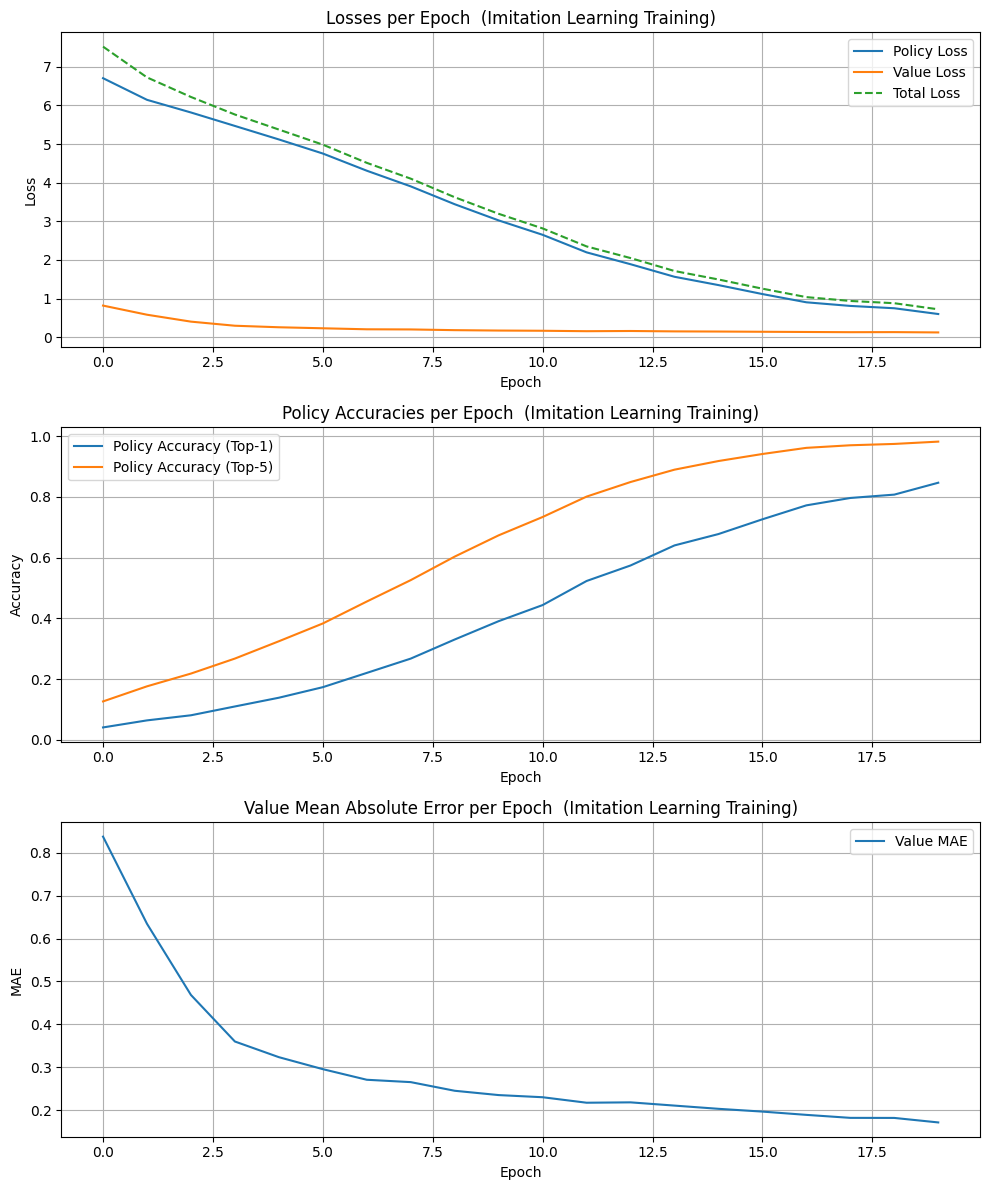

In [ ]:
def plot_imitation_metrics(policy_losses, value_losses, total_losses,
                           policy_acc_top1, policy_acc_top5, value_maes,
                           title_suffix=""):
    if not policy_losses:
        print("No data to plot. Metric lists are empty.")
        return

    num_plots = 3

    fig, axs = plt.subplots(num_plots, 1, figsize=(10, num_plots * 4))

    axs[0].plot(policy_losses, label="Policy Loss")
    axs[0].plot(value_losses, label="Value Loss")
    axs[0].plot(total_losses, label="Total Loss", linestyle='--')
    axs[0].set_title(f"Losses per Epoch {title_suffix}")
    axs[0].set_xlabel("Epoch")
    axs[0].set_ylabel("Loss")
    axs[0].legend()
    axs[0].grid(True)

    axs[1].plot(policy_acc_top1, label="Policy Accuracy (Top-1)")
    axs[1].plot(policy_acc_top5, label="Policy Accuracy (Top-5)")
    axs[1].set_title(f"Policy Accuracies per Epoch {title_suffix}")
    axs[1].set_xlabel("Epoch")
    axs[1].set_ylabel("Accuracy")
    axs[1].legend()
    axs[1].grid(True)

    axs[2].plot(value_maes, label="Value MAE")
    axs[2].set_title(f"Value Mean Absolute Error per Epoch {title_suffix}")
    axs[2].set_xlabel("Epoch")
    axs[2].set_ylabel("MAE")
    axs[2].legend()
    axs[2].grid(True)

    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    magnus_lichess_username = "DrNykterstein"
    game_type_to_download = "blitz"
    number_of_games_to_download = 1000
    output_pgn_file = f"magnus_carlsen_{game_type_to_download}_{number_of_games_to_download}_games_lc0_style.pgn"

    download_magnus_carlsen_game(
        username=magnus_lichess_username,
        max_games=number_of_games_to_download,
        perf_type=game_type_to_download,
        output_filename=output_pgn_file
    )

    X_data, Y_policy_data, Y_value_data = process_pgn_to_training_data_lc0(output_pgn_file, num_history_frames=7)

    if X_data is not None and Y_policy_data is not None and Y_value_data is not None:
        print("\nLc0-style data preparation complete! Proceeding to training.")

        X_tensor_full = torch.from_numpy(X_data).float()
        Y_policy_tensor_full = torch.from_numpy(Y_policy_data).long()
        Y_value_tensor_full = torch.from_numpy(Y_value_data).float().unsqueeze(1)

        full_dataset = TensorDataset(X_tensor_full, Y_policy_tensor_full, Y_value_tensor_full)

        train_size = int(0.8 * len(full_dataset))
        test_size = len(full_dataset) - train_size

        train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

        print(f"Dataset split: Training samples: {len(train_dataset)}, Test samples: {len(test_dataset)}")

        batch_size = 256
        train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
        test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"Using device: {device}")

        model = ChessNet(num_residual_blocks=5, num_channels=128).to(device)
        print(f"Model created with {sum(p.numel() for p in model.parameters() if p.requires_grad)} trainable parameters.")

        criterion_policy = nn.CrossEntropyLoss()
        criterion_value = nn.MSELoss()

        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

        num_epochs = 20

        train_policy_losses = []
        train_value_losses = []
        train_total_losses = []
        train_policy_accuracies_top1 = []
        train_policy_accuracies_top5 = []
        train_value_maes = []

        print("\nStarting training...")
        for epoch in range(num_epochs):
            model.train()
            total_policy_loss_train = 0
            total_value_loss_train = 0
            total_loss_train = 0
            total_correct_moves_top1_train = 0
            total_correct_moves_top5_train = 0
            total_samples_policy_train = 0
            total_abs_value_diff_train = 0
            total_value_samples_train = 0

            for batch_idx, (batch_x, batch_y_policy, batch_y_value) in enumerate(train_dataloader):
                batch_x, batch_y_policy, batch_y_value = batch_x.to(device), batch_y_policy.to(device), batch_y_value.to(device)

                optimizer.zero_grad()
                policy_logits, predicted_value = model(batch_x)
                loss_policy = criterion_policy(policy_logits, batch_y_policy)
                loss_value = criterion_value(predicted_value, batch_y_value)
                loss = loss_policy + loss_value

                loss.backward()
                optimizer.step()

                total_policy_loss_train += loss_policy.item()
                total_value_loss_train += loss_value.item()
                total_loss_train += loss.item()

                _, predicted_moves = torch.max(policy_logits.data, 1)
                total_correct_moves_top1_train += (predicted_moves == batch_y_policy).sum().item()
                total_samples_policy_train += batch_y_policy.size(0)

                top5_predicted_indices = torch.topk(policy_logits.data, k=5, dim=1).indices
                for i in range(batch_y_policy.size(0)):
                    if batch_y_policy[i] in top5_predicted_indices[i]:
                        total_correct_moves_top5_train += 1

                total_abs_value_diff_train += torch.abs(predicted_value - batch_y_value).sum().item()
                total_value_samples_train += batch_y_value.size(0)

            avg_policy_loss_train = total_policy_loss_train / len(train_dataloader)
            avg_value_loss_train = total_value_loss_train / len(train_dataloader)
            avg_total_loss_train = total_loss_train / len(train_dataloader)
            avg_policy_accuracy_top1_train = total_correct_moves_top1_train / total_samples_policy_train if total_samples_policy_train > 0 else 0
            avg_policy_accuracy_top5_train = total_correct_moves_top5_train / total_samples_policy_train if total_samples_policy_train > 0 else 0
            avg_value_mae_train = total_abs_value_diff_train / total_value_samples_train if total_value_samples_train > 0 else 0

            train_policy_losses.append(avg_policy_loss_train)
            train_value_losses.append(avg_value_loss_train)
            train_total_losses.append(avg_total_loss_train)
            train_policy_accuracies_top1.append(avg_policy_accuracy_top1_train)
            train_policy_accuracies_top5.append(avg_policy_accuracy_top5_train)
            train_value_maes.append(avg_value_mae_train)
            print(f"Epoch {epoch+1}/{num_epochs}")
            print(f"  Train -> Policy Loss: {avg_policy_loss_train:.4f}, Policy Acc (Top-1): {avg_policy_accuracy_top1_train:.4f}, Policy Acc (Top-5): {avg_policy_accuracy_top5_train:.4f}, Value Loss: {avg_value_loss_train:.4f}, Value MAE: {avg_value_mae_train:.4f}, Total Loss: {avg_total_loss_train:.4f}")

        print("\nTraining complete!")

        print("\n--- Final Evaluation on Test Data ---")
        model.eval() 
        test_policy_loss = 0
        test_value_loss = 0
        test_total_loss = 0
        test_correct_moves_top1 = 0
        test_correct_moves_top5 = 0
        test_samples_policy = 0
        test_abs_value_diff = 0
        test_value_samples = 0

        with torch.no_grad():
            for batch_x, batch_y_policy, batch_y_value in test_dataloader: 
                batch_x, batch_y_policy, batch_y_value = batch_x.to(device), batch_y_policy.to(device), batch_y_value.to(device)

                policy_logits, predicted_value = model(batch_x)

                loss_policy = criterion_policy(policy_logits, batch_y_policy)
                loss_value = criterion_value(predicted_value, batch_y_value)
                loss = loss_policy + loss_value

                test_policy_loss += loss_policy.item()
                test_value_loss += loss_value.item()
                test_total_loss += loss.item()

                _, predicted_moves = torch.max(policy_logits.data, 1)
                test_correct_moves_top1 += (predicted_moves == batch_y_policy).sum().item()
                test_samples_policy += batch_y_policy.size(0)

                top5_predicted_indices = torch.topk(policy_logits.data, k=5, dim=1).indices
                for i in range(batch_y_policy.size(0)):
                    if batch_y_policy[i] in top5_predicted_indices[i]:
                        test_correct_moves_top5 += 1

                test_abs_value_diff += torch.abs(predicted_value - batch_y_value).sum().item() 
                test_value_samples += batch_y_value.size(0)

        avg_policy_loss_test = test_policy_loss / len(test_dataloader)
        avg_value_loss_test = test_value_loss / len(test_dataloader)
        avg_total_loss_test = test_total_loss / len(test_dataloader)
        avg_policy_accuracy_top1_test = test_correct_moves_top1 / test_samples_policy if test_samples_policy > 0 else 0
        avg_policy_accuracy_top5_test = test_correct_moves_top5 / test_samples_policy if test_samples_policy > 0 else 0
        avg_value_mae_test = test_abs_value_diff / test_value_samples if test_value_samples > 0 else 0

        print(f"  Test  -> Policy Loss: {avg_policy_loss_test:.4f}, Policy Acc (Top-1): {avg_policy_accuracy_top1_test:.4f}, Policy Acc (Top-5): {avg_policy_accuracy_top5_test:.4f}, Value Loss: {avg_value_loss_test:.4f}, Value MAE: {avg_value_mae_test:.4f}, Total Loss: {avg_total_loss_test:.4f}")

        model_save_path = "chess_model_lc0_imitation.pth"
        torch.save(model.state_dict(), model_save_path)
        print(f"Model saved to {model_save_path}")
        plot_imitation_metrics(
            train_policy_losses,
            train_value_losses,
            train_total_losses,
            train_policy_accuracies_top1,
            train_policy_accuracies_top5,
            train_value_maes,
            title_suffix=" (Imitation Learning Training)"
        )

    else:
        print("\nFailed to prepare training data. Training skipped.")